# Figure 8: looking at heterozygosity in class I and class II alleles 
#### Idea from here: https://www.science.org/doi/full/10.1126/science.adi3808

#### NOTE we are expanding this to look at all cancers + CH
#### Plus you want to then combine it with divergence in MHC class I


# Import packages

In [1]:
# imported packages
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import matplotlib.ticker as plticker
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib.patches import Polygon
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib import cm
import scipy.special
import scipy.integrate as it
from scipy import integrate
from scipy.interpolate import interp1d
from scipy.stats import kde
import copy
import glob, os
import re
# from sklearn import datasets, linear_model
import pandas as pd
from decimal import *
from operator import itemgetter    
from collections import OrderedDict
import timeit
import time 
import csv
import seaborn as sns 
import scipy as sp
from sklearn.preprocessing import LabelEncoder
from matplotlib.ticker import LogLocator
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D

from scipy.stats import mannwhitneyu
from scipy.stats import kruskal


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:

axisfont=11
titlefont=20
subtitlefont = 15
axislabelfont=12
legendfont = 11
tpfont = 12
plt.rcParams.update({'font.sans-serif':'Arial'})

In [3]:

timestr = time.strftime("%Y%m%d") # get current date 

# Determine heterozygosity for each CH case


from: https://www.science.org/doi/10.1126/science.adi3808

we defined heterozygosity at each of the eight HLA-I and HLA-II loci as different alleles at 2-field resolution, since the 2-field allele codes represent variation at the amino acid sequence level of the HLA molecules

we next asked whether HLA heterozygosity is associated with reduced lung cancer risk in the UK Biobank by performing a multivariable logistic regression analysis. We controlled for clinical and demographic covariates that are known to influence lung cancer risk and outcomes in the UK Biobank.We reasoned that a multivariable model accounting for all covariates would be especially critical given the drastic difference in age between lung cancer cases in the UK Biobank (median 67)

if you need motivation: further work is needed to clarify the differences between immunosurveillance mediated by HLA-I and HLA-II in early tumor development, including the development of refined models in other cancer types incorporating disease-specific covariates.

STEP BY STEP how we would like to do that

0 compare the frequnecy of alleles in UKBB to this https://academic.oup.com/nar/article/48/D1/D783/5624967 (they do it and it is a useful QC)

1 for each individual in your dataset (everyone you have genotyping data for), determine their heterozygosity for different alleles (A, B, C, DRB, DP, DQ) a

- heterozygosity at each of the eight HLA-I and HLA-II loci as different alleles at 2-field resolution, since the 2-field allele codes represent variation at the amino acid sequence level of the HLA molecules (see this https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1006862)
- the two-field resolution refers to the two fields in the format HLA-A*01:25 where 01 is the first field (indicates allele group) and 25 the second one (indicates protein sequence) source: https://thesequencingcenter.com/what-are-they-differences-between-2-field-and-4-field-reporting-for-hla-typing/
- this means that you basically want to search for people who have different alleles for A, B, C, DRB, DPA, DPB, DQA, DQB
- you should then display the proportion of heterozygous vs homozygous individuals 
- do we have blood cancer data? maybe we could test if this affects the risk of progression from CH to blood cancer risk?

2 I think than you can check proportion of hets vs homs in CH+ / CH- (and then separately for each variant, CH+ for this variant / no CH at all)

3 we can then look at a more complicated model
- what they do in the science paper: "we fit an independent multivariable logistic regression for each HLA locus testing heterozygosity at the locus as a predictor together with clinical and demographic covariates, including smoking status > outcome was a binary variable indicating diagnosis or death due to lung cancer (N = 2468 in the UK Biobank) or healthy control" + "we fit two additional models for maximal heterozygosity at HLA-I (6 alleles versus <6) and maximal heterozygosity at HLA-II (10 alleles versus <10), which is consistent with the original definition of heterozygote advantage" 
- so for us, we can fit a model where we use het at locus X (or het class I / class II - 6 vs fewer alleles), sex, age, smoking status, some demographic data and test if the person has CH (maybe called at different levels: say 2 reads, 4 reads, 7 reads or not - I would have it binary and fit three separate models where 0 is CH- and 1 is CH+ but defined at different levels of clone size - this is quite arbitrary so we may look at some sort of continuous prediction later on)

4 if you get anything significant, can compare to what they got (if are effects most significant for the same alleles etc?)

5 can then look at transcriptomic data in CH and things like that > their analysis is surely very funky (look at peptide binding grooves and things like that)

we can figure out how to do distance once this is done 
- distance can be based on the sequence difference
- or alternatively, you could look at the correlation between scores for different variants
    - are correlations consistent between variants? that would be worth checking 
    - NB NetMHC is known to be a bit shit
    - we can also use PRIME for comparison 


In [4]:

# load the data with genotyping 

# path to file
file_hla = "/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/UKBB/ukb_typed_hla_with_ids_07_threshold_processed.txt"

# get the header 
header = pd.read_csv(file_hla, sep='\t', nrows=1, header=None).values.tolist()
head = [item for sublist in header for item in sublist]

# get the actual dataframe 
df_hla = pd.read_csv(file_hla, skiprows = 1, sep = ' ', header = None)

# add columns 
df_hla.columns = head 

# subset data for HLA-I and HLA-II class alleles 

# split into smaller dfs in case this is needed further down 
df_hla1 = df_hla.filter(regex='^(Person_|A_|B_|C_)') 
df_hla2 = df_hla.filter(regex='^(Person_|D)') 

# rename the column to sample name to match the batch_gene_vars dataframe
df_hla = df_hla.rename(columns={'Person_ID': 'sample_ID'})
df_hla1 = df_hla1.rename(columns={'Person_ID': 'sample_ID'})
df_hla2 = df_hla2.rename(columns={'Person_ID': 'sample_ID'})

df_hla2_dp = df_hla2.filter(regex='^(Person_|DP)')
df_hla2_dq = df_hla2.filter(regex='^(Person_|DQ)')
df_hla2_dr = df_hla2.filter(regex='^(Person_|DR)')

print("Number of samples with genotyped MHC class I alleles:", df_hla1.shape[0])
print("Number of samples with genotyped MHC class II alleles:", df_hla2.shape[0])


Number of samples with genotyped MHC class I alleles: 488377
Number of samples with genotyped MHC class II alleles: 488377


In [5]:

# Count the number of people where genotyping is not certain

# let's first count in how many cases we're not sure on the allele genotype
df_hla1_count_05 = df_hla1.values.flatten().tolist().count(0.5)
df_hla1_count_15 = df_hla1.values.flatten().tolist().count(1.5)

df_hla2_count_05 = df_hla2.values.flatten().tolist().count(0.5)
df_hla2_count_15 = df_hla2.values.flatten().tolist().count(1.5)

print('Number of 0.5 typing for HLA class I:', df_hla1_count_05)
print('Number of 1.5 typing for HLA class I:', df_hla1_count_15)
print('Number of 0.5 typing for HLA class II:', df_hla2_count_05)
print('Number of 1.5 typing for HLA class II:', df_hla2_count_15)

Number of 0.5 typing for HLA class I: 45538
Number of 1.5 typing for HLA class I: 2565
Number of 0.5 typing for HLA class II: 106986
Number of 1.5 typing for HLA class II: 25163



#### To do with missing alleles
where individuals were considered positive for a specific allele if the PPV was ≥0.7 and ≤1.
Individuals with a PPV between 1.5 and 2 for a specific allele at a given locus were marked as having two copies of the allele. Individuals with two nonzero alleles where one or both had a PPV <0.7, or one nonzero allele between 1 and 1.5, at any of the eight HLA loci, were excluded 

#### Options: 
- drop people for whom you do not have the allele data
- if sb has 0.5, convert to 0 


In [16]:

# Option 1: replace missing alleles
df_hla1_rep = df_hla1.replace(0.5, 0)
df_hla1_rep = df_hla1.replace(1.5, 2) # they assume the individual has two alleles in this case 
 
df_hla2_rep = df_hla2.replace(0.5, 0)
df_hla2_rep = df_hla2.replace(1.5, 2) # they assume the individual has two alleles in this case 
 
# create separate DFs for DR, DP, DQ
df_hla2_rep_dp = df_hla2_rep.filter(regex='^(Person_|DP)')
df_hla2_rep_dq = df_hla2_rep.filter(regex='^(Person_|DQ)')
df_hla2_rep_dr = df_hla2_rep.filter(regex='^(Person_|DR)')

# drop missing alleles 
df_hla1_clean = df_hla1[~df_hla1.isin([0.5]).any(axis=1)] # remove rows with 0.5 (don't include the people)
df_hla1_clean = df_hla1.replace(1.5, 2) # we are still assuming this 
 
df_hla2_clean = df_hla2[~df_hla2.isin([0.5]).any(axis=1)] # remove rows with 0.5 (don't include the people)
df_hla2_clean = df_hla2_clean.replace(1.5, 2) # we are still assuming this 
df_hla2_clean_dp = df_hla2_clean.filter(regex='^(Person_|DP)')
df_hla2_clean_dq = df_hla2_clean.filter(regex='^(Person_|DQ)')
df_hla2_clean_dr = df_hla2_clean.filter(regex='^(Person_|DR)')


# Load complete phenotype data

In [19]:

# load datasets with phenotypic data 
pheno_df = pd.read_csv('/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/pheno_info20230504.tsv', sep = '\t')
ancestry_df = pd.read_csv('/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ukb_iadmix_ancestry_props.csv')

pheno_df.head()

/var/folders/pm/9pk2smx14xgfsh10_fdyd_w00000gn/T/ipykernel_64395/3813133044.py:2: DtypeWarning: Columns (62,78,79,87,93,94,101,104,105,106,219,221,242,247,248,249,256,259,260,265,268,361,363,387,388,393,397,398,405,408,471,472,473,474,483,484,485,486,495,496,497,498,500,501,506,507,512,513) have mixed types. Specify dtype option on import or set low_memory=False.
  pheno_df = pd.read_csv('/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/pheno_info20230504.tsv', sep = '\t')


,ID_v0,Sex_v0,Year.of.birth_v0,Waist.circumference_v0,Hip.circumference_v0,Standing.height_v0,Month.of.birth_v0,Date.of.attending.assessment.centre_v0,Date.of.consenting.to.join.UK.Biobank_v0,Current.tobacco.smoking_v0,...,first.diagnosed.cancer.date1,first.diagnosed.cancer.date2,first.diagnosed.cancer.date3,first.diagnosed.cancer.histology1,first.diagnosed.cancer.histology2,first.diagnosed.cancer.histology3,first.diagnosed.cancer.behaviour1,first.diagnosed.cancer.behaviour2,first.diagnosed.cancer.behaviour3,exome200k
0,1000017,Female,1945.0,84.0,106.0,169.0,March,2010-04-13,2010-04-13,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,1000025,Female,1956.0,77.0,98.0,172.0,November,2007-06-19,2007-06-19,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,1000038,Female,1955.0,93.0,113.0,162.0,December,2007-08-28,2007-08-28,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,1000042,Male,1956.0,104.0,110.0,180.0,March,2008-05-02,2008-05-02,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,1000056,Female,1944.0,84.0,91.0,152.0,May,2009-08-07,2009-08-07,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


## Check heterozygosity status

In [14]:

# add columns to indicate heterozygosity status 

# we will first do this for HLA_classI_A, HLA_classI_B, HLA_classI_C, HLA_classII_DRB, HLA_classII_DPA, HLA_classII_DPB, HLA_classII_DQA, HLA_classII_DQB, total_het_I, total_het_II, total_het 
# define a function to get names of columns which indicate alleles present in the sample 
def get_columns_with_values(row, subset_columns):
    return [col for col in subset_columns if row[col] > 0]

In [7]:

# apply function to class I alleles 

# filter columns with MHC class I alleles (start with A_, B_, C_)
subset_A = [col for col in df_hla.columns if col.startswith(('A_'))]
subset_B = [col for col in df_hla.columns if col.startswith(('B_'))]
subset_C = [col for col in df_hla.columns if col.startswith(('C_'))]

subsets_1 = [subset_A, subset_B, subset_C]

for subset in subsets_1:
    
    new_column_name = 'allele_I_' + subset[0][0] # the first letter will indicate class
    df_hla[new_column_name] = df_hla.apply(get_columns_with_values, axis=1, subset_columns=subset).apply(lambda x: ', '.join(x))

df_hla.head(n = 5)

,sample_ID,A_101,A_102,A_103,A_201,A_202,A_203,A_205,A_206,A_207,...,DPA1_104,DPA1_105,DPA1_107,DPA1_201,DPA1_202,DPA1_301,DPA1_401,allele_I_A,allele_I_B,allele_I_C
0,2812213,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A_201,"B_4001, B_4402","C_304, C_501"
1,4860169,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A_101,"B_801, B_5701","C_602, C_701"
2,3381323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"A_2301, A_2402","B_1801, B_5701","C_501, C_602"
3,2805252,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,A_101,"B_702, B_5701","C_602, C_702"
4,1118855,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"A_201, A_1101","B_5501, B_5701","C_303, C_602"


In [8]:

# apply function to class II alleles

subset_DR = [col for col in df_hla.columns if 'DRB1' in col] # this is the only one we want to look at at the moment 
subset_DPA = [col for col in df_hla.columns if 'DPA' in col]
subset_DPB = [col for col in df_hla.columns if 'DPB' in col]
subset_DQA = [col for col in df_hla.columns if 'DQA' in col]
subset_DQB = [col for col in df_hla.columns if 'DQB' in col]

subsets_2 = [subset_DR, subset_DPA, subset_DPB, subset_DQA, subset_DQB]

for subset in subsets_2:
    
    new_column_name = 'allele_II_' + subset[0][:3] # the first three letters indicate class
    df_hla[new_column_name] = df_hla.apply(get_columns_with_values, axis=1, subset_columns=subset).apply(lambda x: ', '.join(x))

df_hla.head(n = 5)

,sample_ID,A_101,A_102,A_103,A_201,A_202,A_203,A_205,A_206,A_207,...,DPA1_301,DPA1_401,allele_I_A,allele_I_B,allele_I_C,allele_II_DRB,allele_II_DPA,allele_II_DPB,allele_II_DQA,allele_II_DQB
0,2812213,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,A_201,"B_4001, B_4402","C_304, C_501","DRB1_401, DRB1_901",DPA1_103,"DPB1_301, DPB1_401",DQA1_301,"DQB1_301, DQB1_303"
1,4860169,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,A_101,"B_801, B_5701","C_602, C_701","DRB1_301, DRB1_1501",DPA1_103,"DPB1_301, DPB1_401","DQA1_102, DQA1_501","DQB1_201, DQB1_602"
2,3381323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,"A_2301, A_2402","B_1801, B_5701","C_501, C_602","DRB1_101, DRB1_401",DPA1_103,"DPB1_201, DPB1_401","DQA1_101, DQA1_301","DQB1_302, DQB1_501"
3,2805252,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,A_101,"B_702, B_5701","C_602, C_702","DRB1_401, DRB1_1501","DPA1_103, DPA1_202","DPB1_101, DPB1_401","DQA1_102, DQA1_301","DQB1_301, DQB1_602"
4,1118855,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,"A_201, A_1101","B_5501, B_5701","C_303, C_602","DRB1_401, DRB1_701",DPA1_103,DPB1_401,"DQA1_201, DQA1_301","DQB1_302, DQB1_303"


In [9]:

# define a function to check if someone is heterozygous for a given class of alleles 
def is_heterozygous_allele(row, col):

    # count the number of alleles someone has 
    # count the number of commas + add 1 = number of entires
    count = row[col].count(',') + 1  
    
    # determine if they are heterozygous or homozygous 
    if count == 2:
        return True # has two alleles so heterozygous
    elif count == 1:
        return False # has 1 alleles so homozygous
    else:
        return None # we definitely should not have anything else !!! so return None and see in how many cases this happens

# list of columns we want to look at to determine heterozygosity status
columns = ['allele_I_A', 'allele_I_B', 'allele_I_C', 'allele_II_DRB', 'allele_II_DPA', 'allele_II_DPB', 'allele_II_DQA', 'allele_II_DQB']

for col in columns:
    new_column_name = 'het_' + col # the first three letters indicate class
    df_hla[new_column_name] = df_hla.apply(is_heterozygous_allele, axis=1, col = col) # add relevant column to the dataframe

In [11]:

# one way to check for total heterozygosity is to see whether you have 'TRUE' in all fields (het_allele A, B, C / het allele DRB, DPA, DPB, DQA, DQB)
df_hla['het_all_class_I_from_allele'] = (df_hla['het_allele_I_A'] & df_hla['het_allele_I_B'] & df_hla['het_allele_I_C'])
df_hla['het_all_class_II_from_allele'] = (df_hla['het_allele_II_DRB'] & df_hla['het_allele_II_DPB'] & df_hla['het_allele_II_DPA'] & df_hla['het_allele_II_DQB'] & df_hla['het_allele_II_DQA'])

In [12]:

# add total heterozygosity 
subset_classI = [col for col in df_hla.columns if col.startswith(('A_', 'B_', 'C_'))] # all class I alleles 
subset_classII = [col for col in df_hla.columns if col.startswith(('D'))] # all class II alleles 

# determine the number of unique alleles typed (so if someone has HLA_A0101, HLA_A0101, HLA_B0101, HLA_B0101, HLA_C0101, HLA_C0101, the count is 3)
df_hla['count_class_I'] = df_hla[subset_classI].gt(0).sum(axis=1)
df_hla['count_class_II'] = df_hla[subset_classII].gt(0).sum(axis=1)

# determine the number of alleles typed (so if someone has HLA_A0101, HLA_A0101, HLA_B0101, HLA_B0101, HLA_C0101, HLA_C0101, the sum is 6)
df_hla['sum_class_I'] = df_hla[subset_classI].sum(axis=1)
df_hla['sum_class_II'] = df_hla[subset_classII].sum(axis=1)


In [13]:
# add columns to indicate total heterozygosity

# note that some people may not have been fully genotyped > I guess we should think about what to do with these cases 

df_hla['het_all_class_I'] = (df_hla['count_class_I'] != 6) # for now let's not worry about this, but we should definitely try and see how it goes with different treatment of these cases
df_hla['het_all_class_II'] = (df_hla['count_class_II'] != 10) 


# Plot percentage of hom / het

In [14]:

# subset the data to only include ID and sums of alleles 
selected_columns = [col for col in df_hla.columns if not col.startswith(('A_', 'B_', 'C_', 'D'))]
subset_df = df_hla[selected_columns]

cols = ['het_all_class_I_from_allele', 'het_all_class_II_from_allele', 'het_allele_I_A', 'het_allele_I_B', 'het_allele_I_C', 
        'het_allele_II_DRB', 'het_allele_II_DQB', 'het_allele_II_DQA', 'het_allele_II_DPB', 'het_allele_II_DPA']
sum_het = [df_hla[col].sum() for col in cols]
total = len(df_hla['sample_ID'].unique())
percent_het= [s / total * 100 for s in sum_het]
percent_hom = [100 - p for p in percent_het]
labels = ['class I', 'class II', 'class I A', 'class I B', 'class I C', 
          'class II DRB1', 'class II DQB', 'class II DQA', 'class II DPB', 'class II DPA']

df_percents = pd.DataFrame([percent_het, percent_hom, labels]).T
df_percents.columns = ['percent_heterozygous', 'percent_homozygous', 'label']


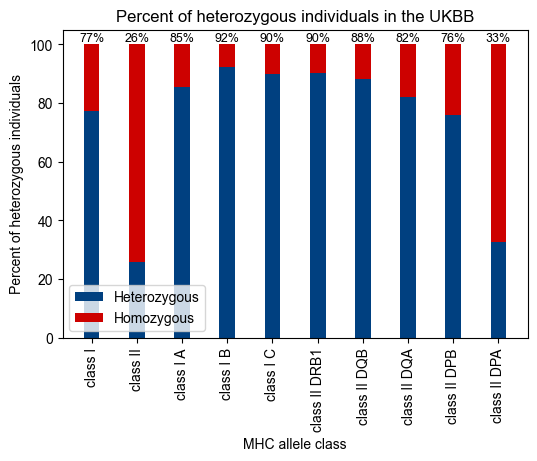

In [15]:
# Plotting

colors = ['#004080', '#cd0100']

plt.figure(figsize=(6, 4))

bar_width = 0.35
bar_positions = range(len(df_percents))

bars_het = plt.bar(bar_positions, df_percents['percent_heterozygous'], color=colors[0], width=bar_width, label='Heterozygous') # het at the bottom
bars_hom = plt.bar(bar_positions, df_percents['percent_homozygous'], color=colors[1], width=bar_width, label='Homozygous', bottom=df_percents['percent_heterozygous']) # stack het on hom

plt.xticks(bar_positions, df_percents['label'])
plt.xlabel('MHC allele class')
plt.ylabel('Percent of heterozygous individuals')
plt.xticks(rotation = 90)
plt.title('Percent of heterozygous individuals in the UKBB')

plt.legend(loc = 'lower left')

for bar1, bar2, percent_1 in zip(bars_het, bars_hom, df_percents['percent_heterozygous']):
    plt.text(bar1.get_x() + bar1.get_width() / 2, bar1.get_height() + bar2.get_height(), f'{round(percent_1)}%', 
             ha='center', va='bottom', fontsize=9, color='black')

plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure8/{timestr}/{timestr}_percent_heterozygous_across_MHC_allele_classes.pdf', bbox_inches='tight')

# our data largely agrees with the paper: https://www.science.org/doi/10.1126/science.adi3808
# the only difference is in class II DPB: I got 76% while they got 87% (nb their Finnish cohort has 76%)


# Add CH data

In [33]:

# add CH annotation to the genotyping data 
folder_path = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ukb_hotspot_calls_annotated'  # Path to ukb files from Hamish 

# Get all files in the folder 
files = glob.glob(os.path.join(folder_path, '*.txt'))  
# print('Files examined are:', files)

# Initialize an empty dictionary 
dataframes = {}

# Iterate through the CSV files and read each one with pandas
for csv_file in files:
    
    df = pd.read_csv(csv_file, sep = '\t')
    dataframes[csv_file] = df

# Extract dataframes 
for file_name, df in dataframes.items():
    
    variable_name = file_name.split('/')[8].split('.')[0] + '_data'  # Removing the file extension
    print('Examined file:', variable_name)
    
    df['batch'] = variable_name # add column to indicate source 
    globals()[variable_name] = df  # assign dataframe to the variable 


# Concat all into one df
dfs_to_concat = [v for k, v in globals().items() if k.endswith('_data') and isinstance(v, pd.DataFrame)]

# Row bind all batch dataframes into a single one 
batch_all = pd.concat(dfs_to_concat, ignore_index=True)
batch_all = batch_all.dropna(subset=['batch']) # remove rows which are read incorrectly (w/o batch number)

print('Number of samples with variants examined:', batch_all.shape[0])


Examined file: batch_21_annotated_data
Examined file: batch_18_annotated_data
Examined file: batch_15_annotated_data
Examined file: batch_11_annotated_data
Examined file: batch_16_annotated_data
Examined file: batch_12_annotated_data
Examined file: batch_13_annotated_data
Examined file: batch_17_annotated_data
Examined file: batch_14_annotated_data
Examined file: batch_19_annotated_data
Examined file: batch_20_annotated_data
Number of samples with variants examined: 76718


In [35]:

# Change numerical variables to integers

batch_all['end_position'] = batch_all['end_position'].astype(int)
batch_all['position'] = batch_all['position'].astype(int)
batch_all['sample_ID'] = batch_all['sample_ID'].astype(int)

# Subset and create new useful columns

batch_all_sel = batch_all[['sample_ID', 'chromosome', 'end_position', 'VAF', 'var_depth', 'depth', 'Amino_acids', 'SYMBOL', 'Codons', 'batch']]
batch_all_sel['alt_variant'] = batch_all_sel['Amino_acids'].str.split('/', expand = True)[1] # alternative (CH) variant
batch_all_sel['ref_variant'] = batch_all_sel['Amino_acids'].str.split('/', expand = True)[0] # reference variant 

# There are some cases where there is no change in amino acids, for now save as NaN 

batch_all_sel['alt_variant'].fillna(batch_all_sel['Amino_acids'], inplace=True)
batch_all_sel['ref_variant'].fillna(batch_all_sel['Amino_acids'], inplace=True)

# Exclude data with singletons (likely errors)

batch_all_ns = batch_all_sel[batch_all_sel['var_depth'] > 1]

# Number of samples with two variant reads or more 
print('Number of samples carrying more than a single read with the variant sequence:', batch_all_ns.shape[0])
batch_all_ns.head(n = 10)


Number of samples carrying more than a single read with the variant sequence: 2823


,sample_ID,chromosome,end_position,VAF,var_depth,depth,Amino_acids,SYMBOL,Codons,batch,alt_variant,ref_variant
41,2100538,chr17,7674894,0.036364,2.0,55.0,R/*,TP53,Cga/Tga,batch_21_annotated_data,*,R
56,2100679,chr2,25234373,0.048780,4.0,82.0,R/H,DNMT3A,cGc/cAc,batch_21_annotated_data,H,R
59,2100706,chr2,25234307,0.019417,2.0,103.0,P/L,DNMT3A,cCg/cTg,batch_21_annotated_data,L,P
64,2100777,chr2,25240313,0.020833,2.0,96.0,R/*,DNMT3A,Cga/Tga,batch_21_annotated_data,*,R
65,2100788,chr2,25240420,0.131148,8.0,61.0,Y/C,DNMT3A,tAc/tGc,batch_21_annotated_data,C,Y
83,2101006,chr2,25240420,0.027778,2.0,72.0,Y/S,DNMT3A,tAc/tCc,batch_21_annotated_data,S,Y
109,2101361,chr17,76736877,0.025641,2.0,78.0,P/H,SRSF2,cCc/cAc,batch_21_annotated_data,H,P
126,2101637,chr2,25240313,0.021739,2.0,92.0,R/*,DNMT3A,Cga/Tga,batch_21_annotated_data,*,R
130,2101708,chr17,7675088,0.033898,2.0,59.0,R/H,TP53,cGc/cAc,batch_21_annotated_data,H,R
154,2102011,chr15,90088702,0.097561,4.0,41.0,R/Q,IDH2,cGg/cAg,batch_21_annotated_data,Q,R


In [18]:

# Import indexes tested in each batch 
folder_path = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ukb_hotspot_calls/batch_ids'  # Path to ukb files from Hamish 

# Get all files in the folder 
files_ids = glob.glob(os.path.join(folder_path, '*.tsv'))  

# Read each file one by one 

indexes = {}

# Iterate through the CSV files and read each one with pandas
for file in files_ids:
    
    id = pd.read_csv(file, sep = '\t')
    id = id.rename(columns={'batch ID': 'sample_ID'})
    id['sample_ID'] = id['sample_ID'].str.split('_', n = 1).str[0]
    indexes[file] = id

for file_name, df in indexes.items():
    
    variable_name = file_name.split('/')[9].split('.')[0]    # Remove file extension
    globals()[variable_name] = df  # Assign the DataFrame to a variable with the file name


In [19]:
# identify IDs of all people examined
batch_all['batch_number'] = batch_all['batch'].apply(lambda x: [int(num) for num in re.findall(r'\d+', x)])
batch_numbers_examined = set(batch_all['batch_number'].sum()) 
print('Batches that were examined for variants:', batch_numbers_examined)

all_dataframes = [f'batch_{i}_ids' for i in range(11, 61)]

# initialize an empty list 
selected_ids = []

# Iterate through all df name 
for df_name in all_dataframes:
    number = int(re.search(r'\d+', df_name).group())
    # check if number matches numbers of batches examined 
    if number in batch_numbers_examined:        
        selected_ids.append(globals()[df_name])


ids_examined = pd.concat(selected_ids, ignore_index=True)
N = ids_examined.shape[0]
print('Number of samples examined for variants:', N)

ids_examined_list = ids_examined['sample_ID'].tolist()


Batches that were examined for variants: {11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}
Number of samples examined for variants: 99597


# Annotate samples with CH variant carried

In [20]:
# Find out how many gene_variants were called:

# don't show warnings 
import warnings
warnings.filterwarnings("ignore")

# identify variants called 
batch_all_ns['variant_coord'] = batch_all_ns['chromosome'].astype(str) + "_" + batch_all_ns['end_position'].astype(str) # specific position in the genome 
batch_all_ns['variant_coord'] = batch_all_ns['variant_coord'].astype('category')
batch_all_ns['variant_coord_pos'] = batch_all_ns['variant_coord'].astype(str) +  "_" + batch_all_ns['SYMBOL'].astype(str) + "_" + batch_all_ns['ref_variant'].astype(str) + "_" + batch_all_ns['alt_variant'].astype(str) # change to a specific aa
batch_all_ns['variant_coord_pos'] = batch_all_ns['variant_coord_pos'].astype('category')

# remove samples that have not been annotated (you can tell from the coordinate what is likely but these could be different mutations)
batch_all_ns = batch_all_ns.dropna(subset=['SYMBOL']) # remove column where gene is not known 

# identify the number of variants in a specific position
num_variants = pd.DataFrame(batch_all_ns['variant_coord_pos'].value_counts())
num_variants = num_variants[num_variants['count']!=0]
num_variants = num_variants.sort_values(by = 'count')
num_variants['variant_coord_pos'] = num_variants.index
num_variants = num_variants.reset_index(drop=True)
num_variants = num_variants.sort_values(by = 'variant_coord_pos')
print('Number of variants identified in batches analysed:', num_variants.shape[0]) # but at each site, you are getting reads modiifed to sth else 

# identify the number of positions we looked at
num_sites = pd.DataFrame(batch_all_ns['variant_coord'].value_counts())
num_sites = num_sites[num_sites['count']!=0]
num_sites = num_sites.sort_values(by = 'count')
num_sites['variant_coord'] = num_sites.index
num_sites = num_sites.reset_index(drop=True)
num_sites = num_sites.sort_values(by = 'variant_coord')
print('Number of sites identified in batches analysed:', num_sites.shape[0]) # okay see so you only found 37 sites 


Number of variants identified in batches analysed: 89
Number of sites identified in batches analysed: 41


In [21]:

# Annotation (using df with variant names and genomic coordinates)

# read in the df with coordinates
coord_gene_var = pd.read_csv('/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ch_variants_coordinates_tp53_added_nts.csv')

# all coordinates identified in the batches  
coord_out = num_sites['variant_coord'].tolist()

# intersection (annotate)
coord_gene_var['variant_coord'] = coord_gene_var['chromosome'] + "_" + coord_gene_var['end_position'].astype(str) # find cariant coordinates
coord_gene_var['SYMBOL'] = coord_gene_var['gene_var'].str.split('_').str[0] # find gene analysed
coord_gene_var['ref_variant'] = coord_gene_var['gene_var'].str.split('_').str[1].str[0] # reference sequence variant 
coord_gene_var['alt_variant'] = coord_gene_var['gene_var'].str.split('_').str[1].str[-1] # alternative sequence (CH / mutation) variant
coord_gene_var['variant_coord_pos'] = coord_gene_var['variant_coord'].astype(str) + "_" + coord_gene_var['SYMBOL'].astype(str) + "_" + coord_gene_var['ref_variant'].astype(str) + "_" + coord_gene_var['alt_variant'].astype(str) # specific mutation 

print('Number of variants which have been investigated:', len(coord_gene_var.variant_coord_pos.unique()))
print('Number of sites which have been investigated:',len(coord_gene_var.variant_coord.unique()))

# NB we removed one variant bc the coordinates were incorrect


Number of variants which have been investigated: 42
Number of sites which have been investigated: 36


In [22]:

# identify CH variants typed in the dataset 
gene_vars = coord_gene_var[['variant_coord_pos', 'gene_var']]

# subset batch df to only include variants which were successfully identified 
batch_gene_vars = pd.merge(batch_all_ns, gene_vars, on = 'variant_coord_pos', how = 'inner')
batch_gene_vars['gene_var'] = batch_gene_vars['gene_var'].astype('category')
batch_gene_vars['gene_var'].value_counts()

gene_vars_count = pd.DataFrame(batch_gene_vars['gene_var'].value_counts())
gene_vars_count['gene_var'] = gene_vars_count.index
gene_vars_count = gene_vars_count.reset_index(drop=True)
gene_vars_sorted = gene_vars_count.sort_values(by = 'count', ascending=False)

print('Number of variants identified with annotations:', gene_vars_sorted.shape[0])
# so we will have 30 variants to look at bc the rest was not mapped correctly 

print('Number of samples examined (with >2 reads):', batch_all_ns.shape[0])
print('Number of patients examined (with >2 reads):', len(batch_all_ns.sample_ID.unique()))
print('Number of samples with annotated variants (with > 2 reads):', batch_gene_vars.shape[0])
print('Number of patients with annotated variants (with > 2 reads):', len(batch_gene_vars.sample_ID.unique()))


Number of variants identified with annotations: 32
Number of samples examined (with >2 reads): 2818
Number of patients examined (with >2 reads): 2761
Number of samples with annotated variants (with > 2 reads): 2249
Number of patients with annotated variants (with > 2 reads): 2214


## Add age data

In [23]:

# load the age dataset 
age_data = pd.read_csv('~/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/2022-05-20_healthy_pheno.tsv', sep = '\t')

age_df = age_data[['ID_v0', 'Age.when.attended.assessment.centre_v0']]
age_df.columns.values[0] = 'sample_ID'
age_df.columns.values[1] = 'age'
print('Number of individuals for whom age data is available:', age_df.shape[0])

Number of individuals for whom age data is available: 459385


In [24]:

# add age data to the rest of the data 

batch_gene_age = pd.merge(batch_gene_vars, age_df, on = 'sample_ID') # add age to everyone who has a variant
print("Number of sample with available CH variant:", batch_gene_vars.shape[0])
print("Number of sample with available CH variant and age:", batch_gene_age.shape[0])
# note: this is throwing away some of your data: presumably the age_df does not have cancer patients which were screened for variants

Number of sample with available CH variant: 2249
Number of sample with available CH variant and age: 1986


## Add MHC genotype data

In [25]:

# merge the dataset with HLA data 

batch_gene_age_hla = pd.merge(batch_gene_age, subset_df, on='sample_ID')
print("Number of samples with available CH variant:", batch_gene_vars.shape[0])
print("Number of samples with available CH variant and age:", batch_gene_age.shape[0])

# in case we just want HLA and we don't care about age (which is fair for now)
batch_gene_hla = pd.merge(batch_gene_vars, subset_df, on='sample_ID')
print('Number of samples with annotated variants CH variant and HLA genotype:', batch_gene_hla.shape[0]) # 1 HLA genotype missing 
print('Number of samples with annotated variants CH variant and age and HLA genotype:', batch_gene_age_hla.shape[0]) # 1 HLA genotype missing 


Number of samples with available CH variant: 2249
Number of samples with available CH variant and age: 1986
Number of samples with annotated variants CH variant and HLA genotype: 2248
Number of samples with annotated variants CH variant and age and HLA genotype: 1985


In [26]:
# I guess we can compare the percentage of heterozygous individuals in CH

# subset the data to only include ID and sums of alleles 

# this is the same as for the entire dataset
selected_columns = [col for col in df_hla.columns if not col.startswith(('A_', 'B_', 'C_', 'D'))]
cols = ['het_all_class_I_from_allele', 'het_all_class_II_from_allele', 'het_allele_I_A', 'het_allele_I_B', 'het_allele_I_C', 
        'het_allele_II_DRB', 'het_allele_II_DQB', 'het_allele_II_DQA', 'het_allele_II_DPB', 'het_allele_II_DPA']
labels = ['class I', 'class II', 'class I A', 'class I B', 'class I C', 
          'class II DRB1', 'class II DQB', 'class II DQA', 'class II DPB', 'class II DPA']

# just for CH cases
sum_het_ch = [batch_gene_hla[col].sum() for col in cols]
total_ch = batch_gene_hla.shape[0] # shoudl change to unique cases for all please!
percent_het_ch = [s / total_ch * 100 for s in sum_het_ch]
percent_hom_ch = [100 - p for p in percent_het_ch]

df_percents_ch = pd.DataFrame([percent_het_ch, percent_hom_ch, labels]).T
df_percents_ch.columns = ['percent_heterozygous', 'percent_homozygous', 'label']


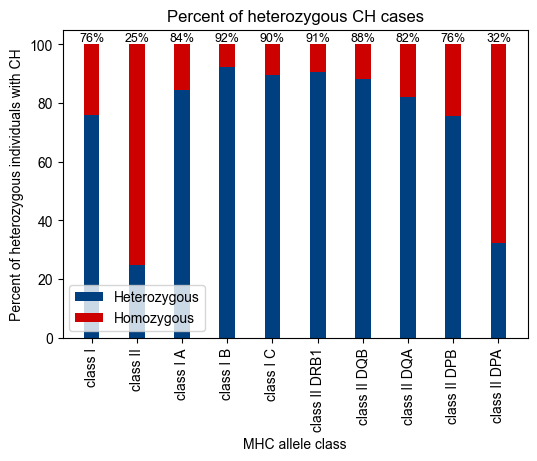

In [27]:
# Plotting

colors = ['#004080', '#cd0100']

plt.figure(figsize=(6, 4))

bar_width = 0.35
bar_positions = range(len(df_percents))

bars_het = plt.bar(bar_positions, df_percents_ch['percent_heterozygous'], color=colors[0], width=bar_width, label='Heterozygous') # het at the bottom
bars_hom = plt.bar(bar_positions, df_percents_ch['percent_homozygous'], color=colors[1], width=bar_width, label='Homozygous', bottom=df_percents_ch['percent_heterozygous']) # stack het on hom

plt.xticks(bar_positions, df_percents_ch['label'])
plt.xlabel('MHC allele class')
plt.ylabel('Percent of heterozygous individuals with CH')
plt.xticks(rotation = 90)
plt.title('Percent of heterozygous CH cases')

plt.legend(loc = 'lower left')

for bar1, bar2, percent_1 in zip(bars_het, bars_hom, df_percents_ch['percent_heterozygous']):
    plt.text(bar1.get_x() + bar1.get_width() / 2, bar1.get_height() + bar2.get_height(), f'{round(percent_1)}%', 
             ha='center', va='bottom', fontsize=9, color='black')

plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure8/{timestr}/{timestr}_percent_heterozygous_across_MHC_allele_classes_ch_only.pdf', bbox_inches='tight')


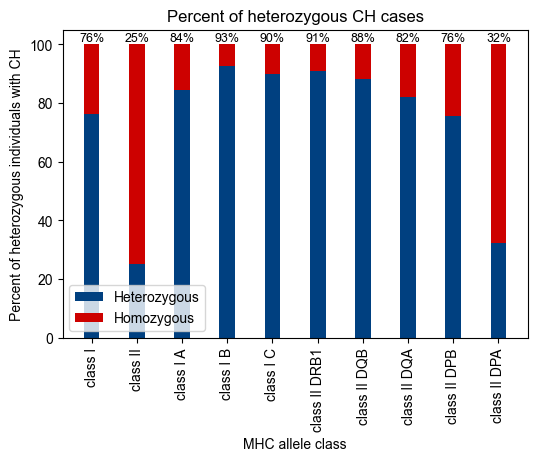

In [28]:

# Now compare to CH individuals for whom you also have age data

# this is the same as for the entire dataset
selected_columns = [col for col in df_hla.columns if not col.startswith(('A_', 'B_', 'C_', 'D'))]
cols = ['het_all_class_I_from_allele', 'het_all_class_II_from_allele', 'het_allele_I_A', 'het_allele_I_B', 'het_allele_I_C', 
        'het_allele_II_DRB', 'het_allele_II_DQB', 'het_allele_II_DQA', 'het_allele_II_DPB', 'het_allele_II_DPA']
labels = ['class I', 'class II', 'class I A', 'class I B', 'class I C', 
          'class II DRB1', 'class II DQB', 'class II DQA', 'class II DPB', 'class II DPA']

# just for CH cases
sum_het_ch = [batch_gene_age_hla[col].sum() for col in cols]
total_ch = batch_gene_age_hla.shape[0] # shoudl change to unique cases for all please!
percent_het_ch = [s / total_ch * 100 for s in sum_het_ch]
percent_hom_ch = [100 - p for p in percent_het_ch]

df_percents_ch = pd.DataFrame([percent_het_ch, percent_hom_ch, labels]).T
df_percents_ch.columns = ['percent_heterozygous', 'percent_homozygous', 'label']

# Plotting
colors = ['#004080', '#cd0100']
plt.figure(figsize=(6, 4))

bar_width = 0.35
bar_positions = range(len(df_percents))

bars_het = plt.bar(bar_positions, df_percents_ch['percent_heterozygous'], color=colors[0], width=bar_width, label='Heterozygous') # het at the bottom
bars_hom = plt.bar(bar_positions, df_percents_ch['percent_homozygous'], color=colors[1], width=bar_width, label='Homozygous', bottom=df_percents_ch['percent_heterozygous']) # stack het on hom

plt.xticks(bar_positions, df_percents_ch['label'])
plt.xlabel('MHC allele class')
plt.ylabel('Percent of heterozygous individuals with CH')
plt.xticks(rotation = 90)
plt.title('Percent of heterozygous CH cases')

plt.legend(loc = 'lower left')

for bar1, bar2, percent_1 in zip(bars_het, bars_hom, df_percents_ch['percent_heterozygous']):
    plt.text(bar1.get_x() + bar1.get_width() / 2, bar1.get_height() + bar2.get_height(), f'{round(percent_1)}%', 
             ha='center', va='bottom', fontsize=9, color='black')

plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure8/{timestr}/{timestr}_percent_heterozygous_across_MHC_allele_classes_ch_only.pdf', bbox_inches='tight')

# Overall, I would conclude that the % heterozygous does not differ between CH cases and the entire population

# Regression model attempt

In [29]:

# okay, so we would like to have a dataframe where we have: all allele data, age, sex, health status (CH / non-CH: based on different read nr), VAF (if CH)

# note: batch gene vars includes all CH cases who have at least 2 reads which correspond to a CH variant 
# all of these individuals have been "annotated" with a variant they carry so these are not just random changes at positions also affected in CH
ch_cases_ids = batch_gene_vars.sample_ID.unique().tolist() # all CH cases
ch_cases_ids = [str(id) for id in ch_cases_ids] # convert to string 

# filter the entire dataframe to include only people you looked at
df_hla['sample_ID'] = df_hla['sample_ID'].astype(str)
df_checked = df_hla[df_hla['sample_ID'].isin(ids_examined_list)]

# now add a column to indicate CH status
df_checked['ch_status'] = df_checked['sample_ID'].isin(ch_cases_ids).astype(int)

cols_to_select = ['sample_ID', 'het_allele_I_A', 'het_allele_I_B', 'het_allele_I_C', 'het_allele_II_DRB', 
                   'het_allele_II_DPB', 'het_allele_II_DPA', 'het_allele_II_DQB', 'het_allele_II_DQA',
                   'het_all_class_I_from_allele', 'het_all_class_II_from_allele', 'count_class_I', 'count_class_II',
                   'sum_class_I', 'sum_class_II', 'ch_status']
df_checked_sub = df_checked[cols_to_select]

print('Number of CH cases:', df_checked.ch_status.sum())
df_checked_sub.head(n = 5)

Number of CH cases: 2213


,sample_ID,het_allele_I_A,het_allele_I_B,het_allele_I_C,het_allele_II_DRB,het_allele_II_DPB,het_allele_II_DPA,het_allele_II_DQB,het_allele_II_DQA,het_all_class_I_from_allele,het_all_class_II_from_allele,count_class_I,count_class_II,sum_class_I,sum_class_II,ch_status
4,1118855,True,True,True,True,False,False,True,True,True,False,6,12,6.0,15.5,0
8,1173923,True,True,True,True,False,False,True,True,True,False,6,12,5.5,16.0,0
9,1734232,False,True,True,True,True,False,False,True,False,False,5,12,6.0,16.0,0
10,1967726,True,True,True,True,False,False,True,True,True,False,6,13,5.5,16.0,0
14,1539760,True,False,False,True,True,False,True,True,False,False,4,13,6.0,16.0,0


In [30]:
# okay so now we will try to do regression which will be really fun xx
from sklearn.linear_model import LogisticRegression

# Sample data
X = df_checked_sub[['het_all_class_I_from_allele', 'het_all_class_II_from_allele']]  # Features
y = df_checked_sub['ch_status']           # Target variable

# Create logistic regression model
model = LogisticRegression()

# Fit the model
model.fit(X, y)

# Print coefficients
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)

Intercept: [-3.71668054]
Coefficients: [[-0.06887901 -0.05413313]]


In [54]:

# add columns with potentially important covariates 

useful_columns = ['sample_ID', 'Sex_v0', 'Age.when.attended.assessment.centre_v2', 'Body.mass.index..BMI._v2', 'Smoking.status_v2']
add_data = batch_all[useful_columns]
add_data['sample_ID'] = add_data['sample_ID'].astype(str)

# add the columns to the dataframe that you have
df_checked_add_data = pd.merge(df_checked_sub, add_data, on = 'sample_ID')


In [135]:

# we want CIs and P-value so seems like this package is most useful 
import statsmodels.api as sm

# first we want to run models with each feature separately
features = ['het_all_class_I_from_allele', 'het_all_class_II_from_allele',
             'het_allele_I_A', 'het_allele_I_B', 'het_allele_I_C', 'het_allele_II_DRB', 
            'het_allele_II_DPB', 'het_allele_II_DPA', 'het_allele_II_DQB', 'het_allele_II_DQA']

dict_glm_intercepts = {}
dict_glm_coeff = {}
dict_glm_confint = {}
dict_glm_pvalues = {}

for feature in features:
    
    X = df_checked_add_data[feature] # Boolean (TRUE / FALSE)
    X = X.astype(int) # numerical (1 / 0)
    y = df_checked_add_data['ch_status']

    # for some features, there is no data
    # for now, if there is no data, just ignore it 

    if not np.isnan(X.astype(float)).any(): # if there are no NaN

        # fit logistic regression model 
        model = sm.Logit(y, sm.add_constant(X))
        result = model.fit()

        # get: intercept, coefficients, confidence interval, p values
        intercept = result.params[0]
        coefficients = result.params[1:]
        confint = result.conf_int()
        pvalues = result.pvalues

        dict_glm_intercepts[feature] = intercept
        dict_glm_coeff[feature] = coefficients
        dict_glm_confint[feature] = confint
        dict_glm_pvalues[feature] = pvalues
        

Optimization terminated successfully.
         Current function value: 0.202985
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.202994
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.202988
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.203036
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.203032
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.203033
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.203026
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.203025
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.203032
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.203035
  

In [235]:
# plot for each feature separately 

# extract values from dictionaries 
values_uni_intercept = list(dict_glm_intercepts.values())
values_uni_coeff = list(dict_glm_coeff.values())
values_uni_confint = list(dict_glm_confint.values())
values_uni_pvalue = list(dict_glm_pvalues.values())

# these are log odds ratios, so we want to convert them to odds ratios
values_uni_intercept_exp = [np.exp(value) for value in values_uni_intercept]
values_uni_coeff_exp = [np.exp(value) for value in values_uni_coeff]
values_uni_confint_exp = [np.exp(value) for value in values_uni_confint] # I have no idea what to do with this 


[-2.830215758231056,
 -2.8882112057426155,
 -2.8090231527068403,
 -2.9086598818903147,
 -2.8784345570044407,
 -2.943147452833511,
 -2.8770614588515557,
 -2.897768241320673,
 -2.8776019553798,
 -2.900191297887585]

In [187]:

# multivariable regression model (all possible useful data I can think about)
features = ['het_all_class_I_from_allele', 'het_all_class_II_from_allele',
             'het_allele_I_A', 'het_allele_I_B', 'het_allele_I_C', 'het_allele_II_DRB', 
            'het_allele_II_DPB', 'het_allele_II_DPA', 'het_allele_II_DQB', 'het_allele_II_DQA']

X = df_checked_add_data[features]
X = X.astype(int)
y = df_checked_add_data['ch_status']

model = sm.Logit(y, sm.add_constant(X))
result = model.fit()
intercept_multi = result.params[0]
coefficients_multi = result.params
confint_multi = result.conf_int()
pvalues_multi = result.pvalues
print('Intercept =', intercept_multi)
print('Coefficients =', coefficients_multi)


Optimization terminated successfully.
         Current function value: 0.202878
         Iterations 7
Intercept = -2.9608204612769478
Coefficients = const                          -2.960820
het_all_class_I_from_allele    -0.152307
het_all_class_II_from_allele   -0.232054
het_allele_I_A                  0.000550
het_allele_I_B                  0.094337
het_allele_I_C                  0.032521
het_allele_II_DRB               0.138819
het_allele_II_DPB              -0.026969
het_allele_II_DPA               0.149551
het_allele_II_DQB              -0.082619
het_allele_II_DQA               0.031640
dtype: float64


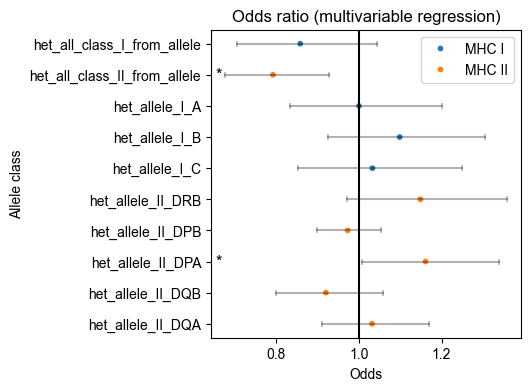

In [231]:

# okay so we have that done so let's plot this 
# this is for MULTI variable regression

log_odds_features_multi = coefficients_multi[1:] # this is the total log odds (baseline + difference)
odds_features_multi = [np.exp(lo) for lo in log_odds_features_multi] # we want to move from log odds to odds 

odds_baseline_multi = np.exp(intercept_multi) # this is the baseline odds ratio (1)
all_odds_ratios = [odds / odds_baseline_multi for odds in odds_features_multi] # change each to odds ratio (odds / baseline)

labels = ['het_all_class_I_from_allele', 'het_all_class_II_from_allele',
            'het_allele_I_A', 'het_allele_I_B', 'het_allele_I_C', 'het_allele_II_DRB', 
            'het_allele_II_DPB', 'het_allele_II_DPA', 'het_allele_II_DQB', 'het_allele_II_DQA']
df_multi_odds = pd.DataFrame({'allele' : labels})
df_multi_odds['odds'] = odds_features_multi
df_multi_odds['odds_ratio'] = all_odds_ratios
df_multi_odds['class'] = ['MHC I', 'MHC II', 'MHC I', 'MHC I','MHC I','MHC II','MHC II','MHC II','MHC II','MHC II' ]

# add confidence intervals
confint_multi_df = pd.DataFrame(confint_multi)
confint_multi_df = confint_multi_df.reset_index()
confint_multi_df = confint_multi_df.rename(columns={'index': 'allele' , 0: 'lower', 1: 'upper'})
confint_multi_df['lower'] = np.exp(confint_multi_df['lower'])
confint_multi_df['upper'] = np.exp(confint_multi_df['upper'])
df_multi_odds = pd.merge(df_multi_odds, confint_multi_df.iloc[1:], on = 'allele')

# add p values
pval_list = pvalues_multi[1:].tolist()
df_multi_odds['p_value'] = pval_list # the first is for the baseline so we don't need that 

# now we can plot that 
plt.figure(figsize = (4,4))

# add confidence intervals
sns.scatterplot(x = df_multi_odds['lower'], y = 'allele', color = 'black', marker='|', data = df_multi_odds, s = 20)
sns.scatterplot(x = df_multi_odds['upper'], y = 'allele', color = 'black', marker='|', data = df_multi_odds, s = 20)

for i in range(len(df_multi_odds['allele'])):
    plt.plot([df_multi_odds['lower'][i], df_multi_odds['upper'][i]], [i, i], color='black', alpha = 0.3)

# add odds (main datapoints)
df_multi_odds['stat_sig'] = [True if df['p_value'] < 0.05 else False]
colors = ['blue', 'red']
sns.scatterplot(x = 'odds', y = 'allele', hue = 'p_value', data = df_multi_odds, s = 40, alpha = 1, palette = colors)

# add vertical line to plot
plt.axvline(x=1, color='black')  # Adjust the x value as needed

# add x and y axis labels
plt.ylabel('Allele class')
plt.xlabel('Odds')
plt.legend()

# add p value annotation - I was planning to do this but adding the color is better
# for i, row in df_multi_odds.iterrows():
#     if row['p_value'] < 0.05:
#         plt.text(0.67, i, '*', fontsize=12, va='center', ha='right')  # Adjust position and size of the star as needed


plt.title('Odds ratio (multivariable regression)')
plt.show()

# this is for UNI variable regression

In [ ]:
# okay let's run this for sex and age (only with the data for which we have this though)

# first we need to find where on earth the sex and age data is, because here we only have Na!!!

features = ['sex', 'age', 'het_all_class_I_from_allele', 'het_all_class_II_from_allele',
             'het_allele_I_A', 'het_allele_I_B', 'het_allele_I_C', 'het_allele_II_DRB', 
            'het_allele_II_DPB', 'het_allele_II_DPA', 'het_allele_II_DQB', 'het_allele_II_DQA']

X = df_checked_add_data[features]
X = X.astype(int)
y = df_checked_add_data['ch_status']

model = sm.Logit(y, sm.add_constant(X))
result = model.fit()
intercept_multi = result.params[0]
coefficients_multi = result.params
confint_multi = result.conf_int()
pvalues_multi = result.pvalues
print('Intercept =', intercept_multi)
print('Coefficients =', coefficients_multi)

# what to do with missing genotypes?

In [20]:
# that is a REALLY considerable amount of people so I feel like it would be worth thinking of what we can do with this 
# do this for the entire dataframe at once

# replace 0.5 > 0, 1.5 > 1
df_to0 = df.replace(0.5, 0)
df_to0 = df_to0.replace(1.5, 1)

# replace 0.5 > 1, 1.5 > 2
df_to1 = df.replace(0.5, 1)
df_to1 = df_to1.replace(1.5, 2)

# remove rows with 0.5 or 1.5
values_to_drop = [0.5, 1.5]
df_drop = df[~df.isin(values_to_drop).any(axis=1)]